Prepare Data for training

In [1]:
import os
import requests
import pandas as pd
from pandas import json_normalize
from decouple import config
from dotenv import load_dotenv
load_dotenv()
                                                        
url = os.environ.get("EXTERNAL_URL") + '/users/user-preference/list'
# url = "http://localhost:8080/users/user-preference/list"
payload={}
headers={}

response=requests.request("GET",url,headers=headers,data=payload)

users=json_normalize(response.json())

data_users=users.iloc[0]

users_df = pd.DataFrame(data_users)

# df_transposed = users_df.transpose()
new_data = []
for i in range(len(users_df[0]['userId'])):
    userId = users_df[0]['userId'][i]
    categories = users_df[0]['categories'][i]

    new_data.append({
        "userId": userId,
        "categories": categories
    })

new_df = pd.DataFrame(new_data)

print(new_df)

                                 userId categories
0  14addfe0-557c-4113-9f86-48ba850d0f22        [8]
1  8c3e5a4e-bee2-4e99-b14e-32268889ae61        [5]
2  d5e35c09-dba0-48ad-b999-aff073fb180e     [3, 7]
3  4f957568-93d2-458c-b7d4-5a6e218ef97a     [6, 8]
4  9cff6c1f-e71d-4063-b72d-8c569626466d  [6, 7, 8]
5  7821d9ce-3545-4dd8-9054-7eadd917b94c  [6, 8, 9]
6  dc86e602-537c-40e6-99cf-0e88044030a1  [4, 5, 8]


In [39]:
new_df

,userId,categories
0,14addfe0-557c-4113-9f86-48ba850d0f22,[8]
1,8c3e5a4e-bee2-4e99-b14e-32268889ae61,[5]
2,d5e35c09-dba0-48ad-b999-aff073fb180e,"[3, 7]"
3,4f957568-93d2-458c-b7d4-5a6e218ef97a,"[3, 7, 8]"
4,9cff6c1f-e71d-4063-b72d-8c569626466d,"[6, 7, 8]"
5,7821d9ce-3545-4dd8-9054-7eadd917b94c,"[6, 8, 9]"
6,dc86e602-537c-40e6-99cf-0e88044030a1,"[4, 5, 8]"


In [2]:
url_events = os.environ.get("EXTERNAL_URL") + "/users/event-preference/list"
payload={}
headers={}

response=requests.request("GET",url_events,headers=headers,data=payload)

events=json_normalize(response.json())

data_eventss=events.iloc[0]

events_df = pd.DataFrame(data_eventss)

new_events_data = []
for i in range(len(events_df[0]['id'])):
    Id = events_df[0]['id'][i]
    name = events_df[0]['name'][i]
    categories = events_df[0]['categories'][i]

    new_events_data.append({
        "id": Id,
        "name": name,
        "categories": categories
    })

events_train_df = pd.DataFrame(new_events_data)

# print(new_df)
events_train_df.head()

,id,name,categories
0,2,Local Creator,"[8, 12]"
1,3,Rabbit Start Meetup: Quickathon ครั้งที่ 1,"[4, 7]"
2,4,ECOSOC Youth Forum,"[5, 11, 12]"
3,6,Workshop ลวดกำมะหยี่ (Velvet Wire),[8]
4,5,ZERO TO CEO – เปลี่ยนไอเดียให้กลายเป็นธุรกิจจริง,"[4, 8]"


category in the system

In [7]:
url_cat=os.environ.get("EXTERNAL_URL") + '/events/categories/list'
payload_cat={}
headers_cat={}

response_cat=requests.request("GET", url_cat ,headers=headers_cat, data=payload_cat)
df_cat=json_normalize(response_cat.json())

categories = []
for i in range(len(df_cat['categories'][0])):
    # print(df_cat['categories'][0][i]['label'])
    categories.append(df_cat['categories'][0][i]['label'])

# print(categories)
cat = categories[2:]
print(cat)

['incubation', 'networking', 'forum', 'exhibition', 'competition', 'workshop', 'campaign', 'esg', 'environment', 'social', 'governance']


In [32]:
users_df = new_df
users_df["userId"]

0    14addfe0-557c-4113-9f86-48ba850d0f22
1    8c3e5a4e-bee2-4e99-b14e-32268889ae61
2    d5e35c09-dba0-48ad-b999-aff073fb180e
3    4f957568-93d2-458c-b7d4-5a6e218ef97a
4    9cff6c1f-e71d-4063-b72d-8c569626466d
5    7821d9ce-3545-4dd8-9054-7eadd917b94c
6    dc86e602-537c-40e6-99cf-0e88044030a1
7    dc86e602-537c-40e6-99cf-0e88044030a1
Name: userId, dtype: object

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# users_df = pd.DataFrame(data_users)
# events_df = pd.DataFrame(data_events)

users_df = new_df
events_df = events_train_df

user_map = {uid: idx for idx, uid in enumerate(users_df["userId"])}
event_map = {eid: idx for idx, eid in enumerate(events_df["id"])}

num_users = len(user_map)
num_events = len(event_map)
embedding_dim = 16  # Size of the latent space

# Create Interaction Matrix (Random)
interaction_matrix = torch.rand((num_users, num_events))

class NCFModel(nn.Module):
    def __init__(self, num_users, num_events, embedding_dim):
        super(NCFModel, self).__init__()
        self.P = nn.Embedding(num_users, embedding_dim)
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.Q = nn.Embedding(num_events, embedding_dim)
        self.event_emb = nn.Embedding(num_events, embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

        self.prediction_layer = nn.Linear(embedding_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, event_ids):
        user_vecs = self.P(user_ids)
        event_vecs = self.Q(event_ids)
        gmf = user_vecs * event_vecs

        p_mlp = self.user_emb(user_ids)
        q_mlp = self.event_emb(event_ids)
        mlp = self.mlp(torch.cat([p_mlp, q_mlp], dim=1))

        x = torch.cat([gmf, mlp], dim=1)
        out = self.prediction_layer(x)
        return self.sigmoid(out).squeeze(1)
    
        # x = torch.cat([user_vecs, event_vecs], dim=1)
        # return self.mlp(x).squeeze(1)
        # return (user_vecs * event_vecs).sum(1)  # Dot product

# Initialize Model
model = NCFModel(num_users, num_events, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Prepare Training Data
# user_ids = torch.tensor([user_map[uid] for uid in users_df["userId"]], dtype=torch.long)
# event_ids = torch.tensor([event_map[eid] for eid in events_df["id"]], dtype=torch.long)
# targets = interaction_matrix[user_ids, event_ids]

user_ids, event_ids = torch.meshgrid(
    torch.arange(num_users), torch.arange(num_events), indexing="ij"
)
user_ids, event_ids = user_ids.flatten(), event_ids.flatten()
targets = interaction_matrix[user_ids, event_ids]

# Train Model
losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(user_ids, event_ids)
    loss = loss_fn(preds, targets)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

# Predict Recommendations
model.eval()

# def new_func(recommended_events):
#     recommended_events = recommended_events.sort_values(by="score", ascending=False)
#     return recommended_events

with torch.no_grad():
    scores = model(user_ids, event_ids)

    # Reshape scores into a DataFrame format
    score_matrix = scores.view(num_users, num_events).numpy()  # Reshape into (users x events)

    preds = model(user_ids, event_ids).numpy()
    targets_np = targets.numpy()

    # Create a recommendations DataFrame
    recommendations = []
    for i, user_id in enumerate(users_df["userId"]):
        user_scores = score_matrix[i]
        user_recommendations = pd.DataFrame({
            "userId": user_id,
            "eventId": events_df["id"],
            "eventName": events_df["name"],
            "score": user_scores
        }).sort_values(by="score", ascending=False)  # Sort by score

        recommendations.append(user_recommendations)

    recommended_events = pd.concat(recommendations)

rmse = np.sqrt(mean_squared_error(targets_np, preds))
mae = mean_absolute_error(targets_np, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

print(recommended_events)

RMSE: 0.0028
MAE: 0.0023
                                 userId  eventId  \
1  14addfe0-557c-4113-9f86-48ba850d0f22        3   
5  14addfe0-557c-4113-9f86-48ba850d0f22        7   
4  14addfe0-557c-4113-9f86-48ba850d0f22        5   
0  14addfe0-557c-4113-9f86-48ba850d0f22        2   
2  14addfe0-557c-4113-9f86-48ba850d0f22        4   
3  14addfe0-557c-4113-9f86-48ba850d0f22        6   
2  8c3e5a4e-bee2-4e99-b14e-32268889ae61        4   
4  8c3e5a4e-bee2-4e99-b14e-32268889ae61        5   
0  8c3e5a4e-bee2-4e99-b14e-32268889ae61        2   
5  8c3e5a4e-bee2-4e99-b14e-32268889ae61        7   
1  8c3e5a4e-bee2-4e99-b14e-32268889ae61        3   
3  8c3e5a4e-bee2-4e99-b14e-32268889ae61        6   
2  d5e35c09-dba0-48ad-b999-aff073fb180e        4   
0  d5e35c09-dba0-48ad-b999-aff073fb180e        2   
3  d5e35c09-dba0-48ad-b999-aff073fb180e        6   
5  d5e35c09-dba0-48ad-b999-aff073fb180e        7   
1  d5e35c09-dba0-48ad-b999-aff073fb180e        3   
4  d5e35c09-dba0-48ad-b999-aff073fb180e

In [4]:
print(user_ids.shape, event_ids.shape)

torch.Size([42]) torch.Size([42])


In [5]:
%pip install torchvision torchview graphviz

Note: you may need to restart the kernel to use updated packages.



(dot.exe:9332): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:6424): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


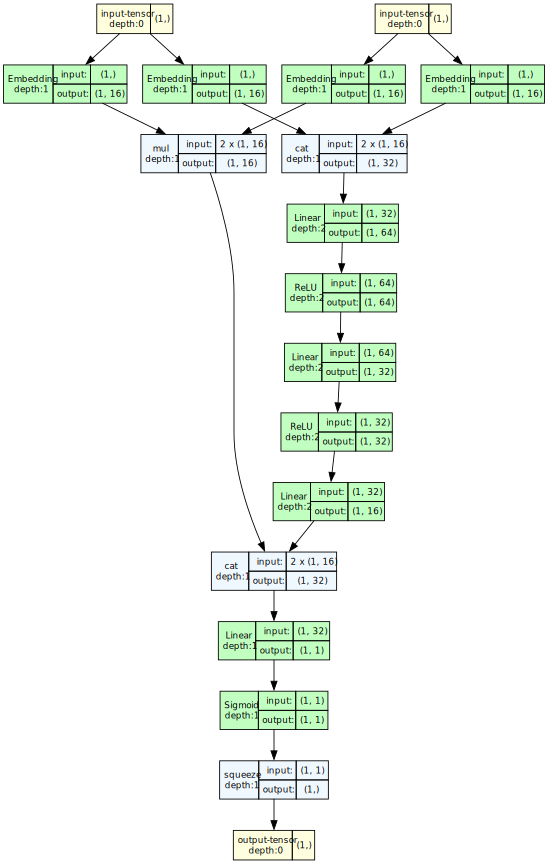

In [6]:
import torchvision
from torchview import draw_graph

# Reuse the existing model
model = NCFModel(num_users, num_events, embedding_dim)

# Sample inputs
user_ids_sample = torch.tensor([0], dtype=torch.long)  # Single user ID
event_ids_sample = torch.tensor([0], dtype=torch.long)  # Single event ID

# Visualize the graph using torchview
model_graph = draw_graph(
    model, 
    input_data=(user_ids_sample, event_ids_sample), 
    graph_name="Neural Collaborative Filtering"
)
model_graph.visual_graph.render(format='png', filename='neural_collaborative_filtering_graph')
model_graph.visual_graph

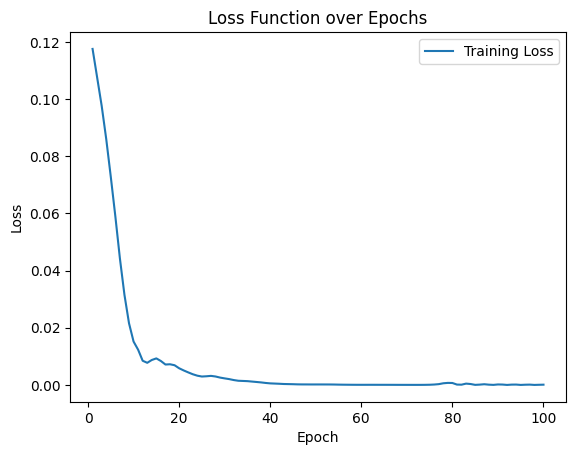

In [7]:
# %pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(range(1, 101), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()

In [8]:
interaction_matrix

tensor([[0.5769, 0.9814, 0.2760, 0.1835, 0.7750, 0.8437],
        [0.3131, 0.2396, 0.9451, 0.2251, 0.8678, 0.2856],
        [0.1999, 0.1383, 0.9773, 0.1869, 0.0950, 0.1788],
        [0.5297, 0.6569, 0.4519, 0.5111, 0.9696, 0.8334],
        [0.7173, 0.1379, 0.1760, 0.8985, 0.7740, 0.1485],
        [0.1190, 0.1953, 0.7978, 0.1708, 0.2994, 0.7659],
        [0.2263, 0.6257, 0.1921, 0.8172, 0.8610, 0.1324]])

In [9]:
model.eval()

with torch.no_grad():
    scores = model(user_ids, event_ids)

score_matrix = scores.view(num_users, num_events).numpy()

# Display the resulting matrix
print(score_matrix)

[[0.44693553 0.66973406 0.6663472  0.53042346 0.51684177 0.5017979 ]
 [0.5675079  0.5818266  0.48442748 0.45328528 0.47991386 0.4894845 ]
 [0.50329757 0.6100011  0.6259469  0.5132008  0.6458184  0.48846826]
 [0.5658685  0.521388   0.56282043 0.58363515 0.45747936 0.47913262]
 [0.5965924  0.4335854  0.58713484 0.71993905 0.5243361  0.47859246]
 [0.52622116 0.4022267  0.49771288 0.57081616 0.52874947 0.51713926]
 [0.37105122 0.5219305  0.45138776 0.62171805 0.49799734 0.55270535]]


In [10]:
grouped_events = recommended_events.groupby('userId')
for user_id, group in grouped_events:
    print(f"User: {user_id}")
    print(group)

User: 14addfe0-557c-4113-9f86-48ba850d0f22
                                 userId  eventId  \
1  14addfe0-557c-4113-9f86-48ba850d0f22        3   
5  14addfe0-557c-4113-9f86-48ba850d0f22        7   
4  14addfe0-557c-4113-9f86-48ba850d0f22        5   
0  14addfe0-557c-4113-9f86-48ba850d0f22        2   
2  14addfe0-557c-4113-9f86-48ba850d0f22        4   
3  14addfe0-557c-4113-9f86-48ba850d0f22        6   

                                           eventName     score  
1         Rabbit Start Meetup: Quickathon ครั้งที่ 1  0.975970  
5  Smart Start Idea by GSB Startup 2568 กิจกรรมดี...  0.845345  
4   ZERO TO CEO – เปลี่ยนไอเดียให้กลายเป็นธุรกิจจริง  0.776142  
0                                      Local Creator  0.579107  
2                                 ECOSOC Youth Forum  0.276126  
3                 Workshop ลวดกำมะหยี่ (Velvet Wire)  0.184865  
User: 4f957568-93d2-458c-b7d4-5a6e218ef97a
                                 userId  eventId  \
4  4f957568-93d2-458c-b7d4-5a6e218ef97a   

In [11]:
torch.save(model.state_dict(), "ncf_model.pth")